<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

In [2]:
import time
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from func.propagation import prop2d, defmodel
from func.inversion import J,second_order_derivative
from func.velocity_model import check_model, gaussian2d

import tensorflow as tf
import tensorflow_probability as tfp
print('GPU:',tf.config.list_physical_devices('GPU'))
from func.propagation_tf import simulate_obs

import cupy as cp
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# # Mapping function from u to v
# def f(u, vmin=2000, vmax=3000):
#     # CDF of gaussian
#     cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
#     v = (vmax-vmin) * cdf + vmin
#     return v

def f(u, a=2000, b=3000):
	v = a+(b-a)/(1+np.exp(-u))

	return v


def f_inv(v, a=2000, b=3000):
	u = np.log(v - a) - np.log(b - v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return log_likelihood

# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd = prop2d(wsrc,zxsrc,v,at,az,ax,next, device)
	receiver_depth = zxrec[0]
	d = p_fwd[zxrec[0], zxrec[1], :]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back = prop2d(np.flip(residual,axis=1), zxrec, v, at, az, ax, next, device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return (dloglik_dv.flatten() * dv_du.flatten())

GPU: []


KL divergence is defined as:

$$KL(q(v) || p(v|d_{obs})) = E_q[\log \frac{q(v)}{p(v|d_{obs})}]$$

Using Bayes' theorem, we can express the true posterior as:

$$p(v|d_{obs}) = \frac{p(d_{obs}|v)p(v)}{p(d_{obs})}$$

Substituting this into the definition of the KL divergence gives:

$$KL(q(v) || p(v|d_{obs})) = E_q[\log \frac{q(v)}{p(d_{obs}|v)p(v)/p(d_{obs})}]$$

$$= E_q[\log \frac{q(v)}{p(d_{obs}|v)p(v)}] + \log p(d_{obs})$$

The objective function is:

$$\text{ELBO} = \mathbb{E}{q(v)}[\log p(d{obs}|v)] + \mathbb{E}{q(v)}[\log p(v)] - \mathbb{E}{q(v)}[\log q(v)] - \log p(d_{obs})$$
where $\log p(d_{obs}|v)$ is the log-likelihood of the data given the latent variables, $\log p(v)$ is the prior distribution over the latent variables, $\log q(v)$ is the log of the variational distribution, and $\log p(d_{obs})$ is a constant term that does not depend on $v$ and can be ignored during optimization.

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 104


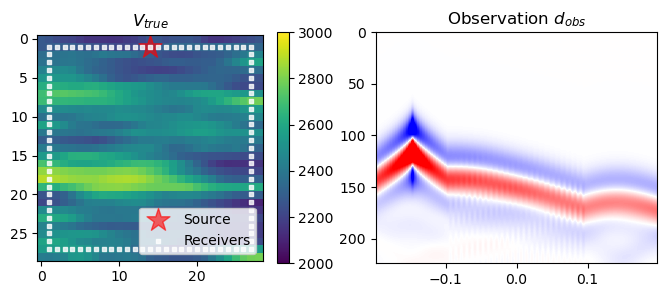

In [4]:
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  

# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
# zxrec = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1))) # Right
zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
zxrec = np.unique(zxrec,axis=1)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

# Set up the optimization and defines the prior and variational posterior distributions

In [5]:
# Define the number of iterations for the optimization
num_iters = 100
# Define the number of samples for the variational posterior
num_samples = 10

# Define the prior distribution for the model parameters
std_noise = 0.1
# prior_cov = np.linalg.inv(Q)
prior_mean = tf.zeros(nz*nx, dtype=tf.float32)
prior_cov = 1/Q.diagonal()
prior_scale = tf.cast(tf.sqrt(prior_cov), dtype=tf.float32)

# Define the TensorFlow probability distributions for the likelihood and prior
d_obs_dist = tfp.distributions.MultivariateNormalDiag(loc=d_obs, scale_diag=tf.ones_like(d_obs)*std_noise)
p_dist = tfp.distributions.MultivariateNormalDiag(loc=prior_mean, scale_diag=prior_scale)

# Define the TensorFlow variables for the variational posterior mean and scale
q_mean = tf.Variable(tf.random.normal([nz*nx], dtype=tf.float32))
# Use Transformed Variable to ensure that the variable remains positive during optimization.
q_scale = tfp.util.TransformedVariable(prior_scale, tfp.bijectors.Exp(), trainable=True)
# Initial q
q_mean = tf.Variable(prior_mean)

# Set up lists to store progress
neg_loglik_history = []
kl_history = []
neg_elbo_history = []

optimizer = tf.keras.optimizers.Adam()

2023-03-13 17:42:00.150342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Training the Variational Posterior with Neg-ELBO Objective

In [6]:
# Set the learning rate for the optimizer
optimizer.learning_rate = 0.1
print(f"Initial learning rate: {optimizer.learning_rate.numpy()}")
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)

# Train the variational posterior using the ELBO objective
for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}")
    
    with tf.GradientTape() as tape:
        # Watch the parameters of the variational posterior
        tape.watch([q_mean, q_scale.trainable_variables[0]])
        
        # Sample from the variational posterior
        q_dist = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)
        
        # Compute the log(d_obs|v) log-likelihood and its gradient
        log_likelihoods = []
        grads_log_likelihoods = []
            
        # Compute the gradient of u with respect to q_mean and q_scale
        with tf.GradientTape() as tape2:
            tape2.watch([q_mean, q_scale.trainable_variables[0]])
            u_samples = q_dist.sample(num_samples)
            du_dq = tape2.gradient(u_samples, [q_mean, q_scale.trainable_variables[0]])
        
        for u in u_samples:
            log_likelihoods.append(loglik_fn(u.numpy(),d_obs,*args))
            grads_log_likelihoods.append(dloglik_du_fn(u.numpy(),d_obs,*args))
        
        # Compute log likelihoods and grad of log-likelihoods
        E_log_likelihoods = tf.cast(tf.reduce_mean(log_likelihoods), dtype=tf.float32)
        grads_E_log_likelihoods = tf.cast(tf.reduce_mean(grads_log_likelihoods,axis=0) * du_dq, dtype=tf.float32)
        grads_E_log_likelihoods = tf.unstack(grads_E_log_likelihoods, axis=0)
        
        # # Compute log(q) entropy terms and gradient of entropy
        # log_q = q_dist.log_prob(u_samples)
        # E_log_q= tf.reduce_mean(log_q)
        # grads_E_entropy = tape.gradient(E_log_q, [q_mean, q_scale.trainable_variables[0]])

        # Compute the KL(q||p) term 
        kl_divergence_q_p = tfp.distributions.kl_divergence(q_dist, p_dist)
        grads_kl_divergence_q_p = tape.gradient(kl_divergence_q_p, [q_mean, q_scale.trainable_variables[0]])
        
        # Compute negative ELBO (to minimize)
        neg_elbo = -E_log_likelihoods + kl_divergence_q_p
        
        # Print and save the values of the neg-log-likelihood, KL(q||p), and negative ELBO
        print(f"Neg log p(dobs|v): {-E_log_likelihoods.numpy():.4f}  KL(q||p): {kl_divergence_q_p.numpy():.4f}  Neg ELBO: {neg_elbo.numpy():.4f}")
        neg_loglik_history.append(-E_log_likelihoods.numpy())
        kl_history.append(kl_divergence_q_p.numpy())
        neg_elbo_history.append(neg_elbo.numpy())

    # Compute gradients of the negative ELBO with respect to q_mean and q_scale
    # and apply them to the optimizer
    grads = [-g for g in grads_E_log_likelihoods] + \
            [g if g is not None else 0 for g in grads_kl_divergence_q_p]
    optimizer.apply_gradients(zip(grads, [q_mean, q_scale.trainable_variables[0]]))


Initial learning rate: 0.10000000149011612
Iteration 1/100
Neg log p(dobs|v): 23249.5957  KL(q||p): 0.0000  Neg ELBO: 23249.5957
Iteration 2/100
Neg log p(dobs|v): 17291.0430  KL(q||p): 288.1257  Neg ELBO: 17579.1680
Iteration 3/100
Neg log p(dobs|v): 12785.7617  KL(q||p): 1081.4995  Neg ELBO: 13867.2617
Iteration 4/100
Neg log p(dobs|v): 9749.8428  KL(q||p): 2250.7451  Neg ELBO: 12000.5879
Iteration 5/100
Neg log p(dobs|v): 6655.0889  KL(q||p): 3703.4150  Neg ELBO: 10358.5039
Iteration 6/100
Neg log p(dobs|v): 5157.0996  KL(q||p): 5310.4619  Neg ELBO: 10467.5615
Iteration 7/100
Neg log p(dobs|v): 4127.0894  KL(q||p): 6979.3604  Neg ELBO: 11106.4492
Iteration 8/100
Neg log p(dobs|v): 3306.3127  KL(q||p): 8645.1562  Neg ELBO: 11951.4688
Iteration 9/100
Neg log p(dobs|v): 2936.1294  KL(q||p): 10252.2373  Neg ELBO: 13188.3672
Iteration 10/100
Neg log p(dobs|v): 2684.0225  KL(q||p): 11736.5352  Neg ELBO: 14420.5576
Iteration 11/100
Neg log p(dobs|v): 2591.2339  KL(q||p): 13067.2812  Neg EL

# Visualization of Prior and Posterior Distributions and Training History

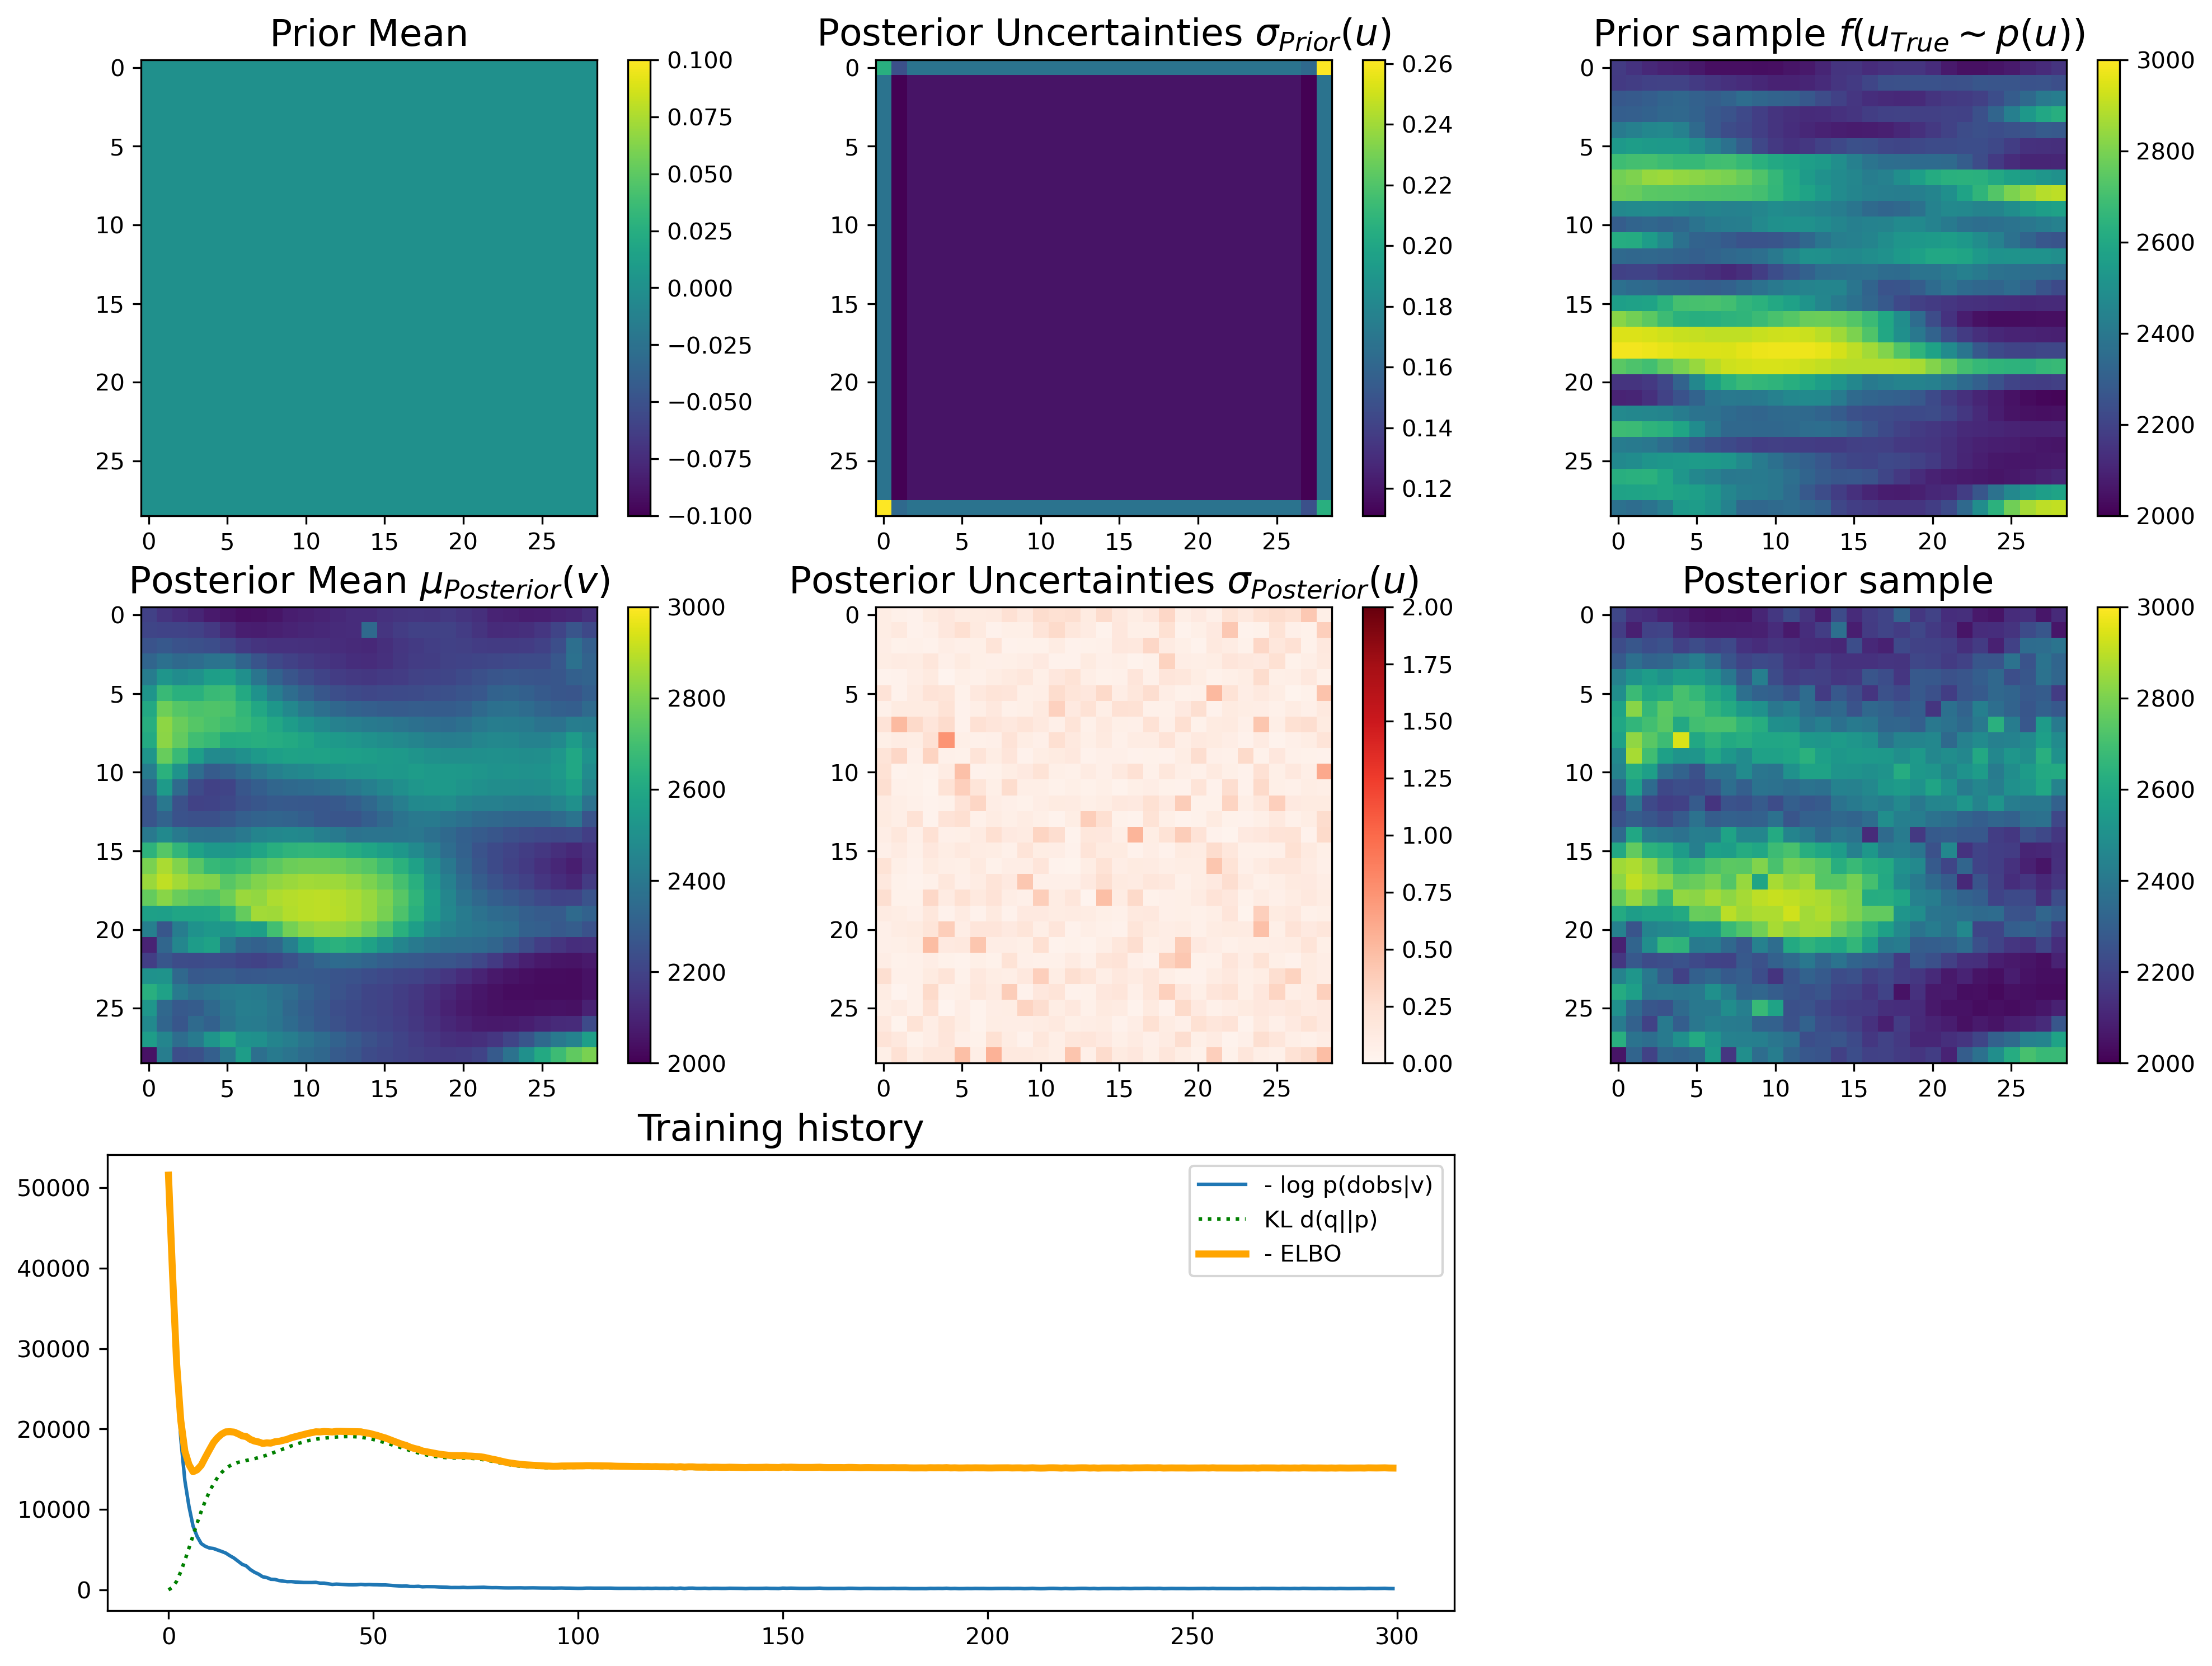

In [90]:
q_posterior = tfp.distributions.MultivariateNormalDiag(loc=q_mean, scale_diag=q_scale)

plt.figure(figsize=(16,12),dpi=300)
plt.subplot(3,3,1)
plt.imshow(tf.reshape(p_dist.mean(),[nz,nx]))
plt.colorbar()
plt.title("Prior Mean", fontsize=16)

plt.subplot(3,3,2)
plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]))
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{Prior}(u)$", fontsize=16)

plt.subplot(3,3,3)
plt.imshow(f(u_ref).reshape((nz,nx)), vmin=2000, vmax=3000)
plt.colorbar()
plt.title("Prior sample $f(u_{True} \sim p(u))$", fontsize=16)

plt.subplot(3,3,4)
plt.imshow(f(q_posterior.mean().numpy()).reshape((nz,nx)), vmin=2000, vmax=3000)
plt.colorbar()
plt.title("Posterior Mean $\mu_{Posterior}(v)$", fontsize=16)

plt.subplot(3,3,5)
plt.imshow(tf.reshape(q_posterior.stddev(),[nz,nx]),cmap='Reds',vmin=0,vmax=2)
plt.colorbar()
plt.title("Posterior Uncertainties $\sigma_{Posterior}(u)$", fontsize=16)

plt.subplot(3,3,6)
plt.imshow(f(q_posterior.sample().numpy()).reshape((nz,nx)), vmin=2000, vmax=3000)
plt.colorbar()
plt.title("Posterior sample", fontsize=16)

plt.subplot(3,3,(7,8))
plt.plot(neg_loglik_history, label='- log p(dobs|v)')
plt.plot(kl_history, ls=":", label='KL d(q||p)', color='green')
plt.plot(neg_elbo_history, lw=3, label='- ELBO', color='orange')
plt.title("Training history", fontsize=16)
plt.legend()
plt.show()